In [1]:
import pandas as pd
from tabulate import tabulate
from scipy.stats import ttest_ind
import warnings
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import precision_recall_curve
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
pd.set_option('display.max_columns', None)
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_curve, roc_auc_score, make_scorer
from sklearn.model_selection import learning_curve


In [2]:
play2024_df = pd.read_csv("data/play_by_play_2024.csv")
injury2024_df = pd.read_csv("data/injuries_2024.csv")

/var/folders/rx/0shr4jt1365bgrnlk6fkmjjh0000gn/T/ipykernel_13030/865703963.py:1: DtypeWarning: Columns (179,180,182,183,189,190,197,198,203,204,205,206,222,224,226,233,234,235,236,237,238,253,254,255,260,262,263,283,284) have mixed types. Specify dtype option on import or set low_memory=False.
  play2024_df = pd.read_csv("data/play_by_play_2024.csv")


In [3]:
def first_last_a(name):
    parts = name.split(" ", 1)
    return f"{parts[0][0]}.{parts[1]}"

In [4]:
def first_last_b(name):
    parts = name.split(" ", 1)
    return f"{parts[0][0:2]}.{parts[1]}"

In [5]:
warnings.filterwarnings('ignore')

def merge_play_injury_dfs(play_df, injury_df):

    # preprocessing
    injury_df["date"] = pd.to_datetime(injury_df['date_modified'])
    play_df["date"] = pd.to_datetime(play_df['game_date'])
    injury_df['date'] = injury_df['date'].dt.tz_localize(None)
    play_df['date'] = play_df['date'].dt.tz_localize(None)

    # filtering
    plays_with_injuries = play_df[play_df['desc'].str.contains("was injured", na=False)]
    pattern = r'(\w+\.(?:\w|-|\.|\')+(?: \w+)*) was injured'
    # Extract the injured player's name from the desc column
    injured_players = plays_with_injuries.loc[:, "desc"].str.extract(pattern)

    # concatenation
    plays_with_injuries = pd.concat([plays_with_injuries, injured_players], axis=1)
    plays_with_injuries.rename(columns={0: "injured_player"}, inplace=True)
    plays_with_injuries = plays_with_injuries.reset_index(drop=True)
    
    # merging
    injuries = []
    for (week, team), group_injury_df in injury_df.groupby(['week', 'team']):
        group_play_df = plays_with_injuries[(plays_with_injuries['week'] == week) & ((plays_with_injuries['home_team'] == team) | (plays_with_injuries['away_team'] == team))]

        group_injury_df = group_injury_df[group_injury_df.date >= group_play_df.date.max()]

        group_injury_df["first_type"] = group_injury_df['full_name'].apply(first_last_a)
        group_injury_df["second_type"] = group_injury_df['full_name'].apply(first_last_b)

        x = pd.merge(group_play_df, group_injury_df, left_on="injured_player", right_on="first_type", how="inner")
        y = pd.merge(group_play_df, group_injury_df, left_on="injured_player", right_on="second_type", how="inner")

        injuries.append(pd.concat([x, y], axis = 0, ignore_index=True))

    plays_with_injuries_and_injury_record = (pd.concat(injuries, axis=0, ignore_index=True)).drop(columns=["first_type", "second_type"])
    plays_with_injuries_and_injury_record = plays_with_injuries_and_injury_record.sort_values('play_id', ascending=False).drop_duplicates(subset=['week_x', 'full_name', "team"], keep='first')

    return plays_with_injuries, plays_with_injuries_and_injury_record
#returns (plays where injuries occurred, plays were injuries occurred and missed time)



In [6]:
def populate_cols_in_play_df(play_df, plays_with_injuries, plays_with_injuries_and_injury_record):
    columns_to_check = ['play_id', 'game_id']
    play_df["was_injured"] = 0
    play_df["missed_time"] = 0
    play_df.loc[play_df[columns_to_check].apply(tuple, 1).isin(plays_with_injuries[columns_to_check].apply(tuple, 1)), 'was_injured'] = 1
    play_df.loc[play_df[columns_to_check].apply(tuple, 1).isin(plays_with_injuries_and_injury_record[columns_to_check].apply(tuple, 1)), 'missed_time'] = 1

    return play_df

In [7]:
plays_with_injuries_2024, plays_with_injuries_and_injury_record_2024 = merge_play_injury_dfs(play2024_df, injury2024_df)


In [8]:
# Print number of rows for each returned table
print("Rows in plays_with_injuries_2024:", len(plays_with_injuries_2024))
print("Rows in plays_with_injuries_and_injury_record_2024:", len(plays_with_injuries_and_injury_record_2024))


Rows in plays_with_injuries_2024: 457
Rows in plays_with_injuries_and_injury_record_2024: 185


In [9]:
play2024_df = populate_cols_in_play_df(play2024_df, plays_with_injuries_2024, plays_with_injuries_and_injury_record_2024)

### MODELING 

In [10]:
# dropping meta data columns
play2024_df = play2024_df.drop(columns=["play_id","game_id","old_game_id"])

In [11]:
#number of columns that have numerical values
num_cols = play2024_df.select_dtypes(include=[np.number]).columns
#keep only numerical columns
#play2024_df = play2024_df[num_cols]
#fill NaN values with 0

In [12]:
play2024_df = play2024_df.fillna(0)

In [13]:
play2024_df.head()

,home_team,away_team,season_type,week,posteam,posteam_type,defteam,side_of_field,yardline_100,game_date,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,game_half,quarter_end,drive,sp,qtr,down,goal_to_go,time,yrdln,ydstogo,ydsnet,desc,play_type,yards_gained,shotgun,no_huddle,qb_dropback,qb_kneel,qb_spike,qb_scramble,pass_length,pass_location,air_yards,yards_after_catch,run_location,run_gap,field_goal_result,kick_distance,extra_point_result,two_point_conv_result,home_timeouts_remaining,away_timeouts_remaining,timeout,timeout_team,td_team,td_player_name,td_player_id,posteam_timeouts_remaining,defteam_timeouts_remaining,total_home_score,total_away_score,posteam_score,defteam_score,score_differential,posteam_score_post,defteam_score_post,score_differential_post,no_score_prob,opp_fg_prob,opp_safety_prob,opp_td_prob,fg_prob,safety_prob,td_prob,extra_point_prob,two_point_conversion_prob,ep,epa,total_home_epa,total_away_epa,total_home_rush_epa,total_away_rush_epa,total_home_pass_epa,total_away_pass_epa,air_epa,yac_epa,comp_air_epa,comp_yac_epa,total_home_comp_air_epa,total_away_comp_air_epa,total_home_comp_yac_epa,total_away_comp_yac_epa,total_home_raw_air_epa,total_away_raw_air_epa,total_home_raw_yac_epa,total_away_raw_yac_epa,wp,def_wp,home_wp,away_wp,wpa,vegas_wpa,vegas_home_wpa,home_wp_post,away_wp_post,vegas_wp,vegas_home_wp,total_home_rush_wpa,total_away_rush_wpa,total_home_pass_wpa,total_away_pass_wpa,air_wpa,yac_wpa,comp_air_wpa,comp_yac_wpa,total_home_comp_air_wpa,total_away_comp_air_wpa,total_home_comp_yac_wpa,total_away_comp_yac_wpa,total_home_raw_air_wpa,total_away_raw_air_wpa,total_home_raw_yac_wpa,total_away_raw_yac_wpa,punt_blocked,first_down_rush,first_down_pass,first_down_penalty,third_down_converted,third_down_failed,fourth_down_converted,fourth_down_failed,incomplete_pass,touchback,interception,punt_inside_twenty,punt_in_endzone,punt_out_of_bounds,punt_downed,punt_fair_catch,kickoff_inside_twenty,kickoff_in_endzone,kickoff_out_of_bounds,kickoff_downed,kickoff_fair_catch,fumble_forced,fumble_not_forced,fumble_out_of_bounds,solo_tackle,safety,penalty,tackled_for_loss,fumble_lost,own_kickoff_recovery,own_kickoff_recovery_td,qb_hit,rush_attempt,pass_attempt,sack,touchdown,pass_touchdown,rush_touchdown,return_touchdown,extra_point_attempt,two_point_attempt,field_goal_attempt,kickoff_attempt,punt_attempt,fumble,complete_pass,assist_tackle,lateral_reception,lateral_rush,lateral_return,lateral_recovery,passer_player_id,passer_player_name,passing_yards,receiver_player_id,receiver_player_name,receiving_yards,rusher_player_id,rusher_player_name,rushing_yards,lateral_receiver_player_id,lateral_receiver_player_name,lateral_receiving_yards,lateral_rusher_player_id,lateral_rusher_player_name,lateral_rushing_yards,lateral_sack_player_id,lateral_sack_player_name,interception_player_id,interception_player_name,lateral_interception_player_id,lateral_interception_player_name,punt_returner_player_id,punt_returner_player_name,lateral_punt_returner_player_id,lateral_punt_returner_player_name,kickoff_returner_player_name,kickoff_returner_player_id,lateral_kickoff_returner_player_id,lateral_kickoff_returner_player_name,punter_player_id,punter_player_name,kicker_player_name,kicker_player_id,own_kickoff_recovery_player_id,own_kickoff_recovery_player_name,blocked_player_id,blocked_player_name,tackle_for_loss_1_player_id,tackle_for_loss_1_player_name,tackle_for_loss_2_player_id,tackle_for_loss_2_player_name,qb_hit_1_player_id,qb_hit_1_player_name,qb_hit_2_player_id,qb_hit_2_player_name,forced_fumble_player_1_team,forced_fumble_player_1_player_id,forced_fumble_player_1_player_name,forced_fumble_player_2_team,forced_fumble_player_2_player_id,forced_fumble_player_2_player_name,solo_tackle_1_team,solo_tackle_2_team,solo_tackle_1_player_id,solo_tackle_2_player_id,solo_tackle_1_player_name,solo_tackle_2_player_name,assist_tackle_1_player_id,assist_tackle_1_player_name,assist_tackle_1_team,assist_tackle_2_player_id,assist_tackle

In [14]:
#splitting data into training and testing
X = play2024_df.drop(columns=["was_injured", "missed_time"])
y = play2024_df["was_injured"]

In [15]:
print("X shape:", X.shape)

X shape: (26345, 370)


In [16]:
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
label_encoder = LabelEncoder()

for col in categorical_cols:
    if X[col].dtype == 'object':
        X[col] = label_encoder.fit_transform(X[col].astype(str))

X['date'] = pd.to_datetime(X['date'])

X['game_month'] = X['date'].dt.month
X['game_day'] = X['date'].dt.day

# Drop the original 'game_date' column if not needed
X = X.drop(columns=['date'])

In [17]:
def remove_low_variance_features(X, threshold=0.01):
    selector = VarianceThreshold(threshold=threshold)
    selector.fit(X)
    return X.columns[selector.get_support()]

In [18]:
low_variance_features = remove_low_variance_features(X)
# remove low variance features
X = X[low_variance_features]

print("Number of features after removing low variance features:", len(X.columns))

Number of features after removing low variance features: 284


In [19]:
print("Number of low variance features:", len(low_variance_features))

Number of low variance features: 284


In [20]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

In [21]:
fvalue_selector = SelectKBest(f_classif, k=128)
X_kbest = fvalue_selector.fit_transform(X, y)

In [22]:
print('Original number of features:', X.shape[1])
print('Reduced number of features:', X_kbest.shape[1])

Original number of features: 284
Reduced number of features: 128


In [23]:
X = pd.DataFrame(X_kbest)

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import KFold, StratifiedKFold

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [26]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("Distribution of classes in y_train:", y_train.value_counts())
print("---------------------")
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print("Distribution of classes in y_test:", y_test.value_counts())

X_train shape: (23710, 128)
y_train shape: (23710,)
Distribution of classes in y_train: was_injured
0    23301
1      409
Name: count, dtype: int64
---------------------
X_test shape: (2635, 128)
y_test shape: (2635,)
Distribution of classes in y_test: was_injured
0    2587
1      48
Name: count, dtype: int64


In [27]:
smote = SMOTE(sampling_strategy='minority', random_state=42, k_neighbors=10)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Distribution of classes in y_train_resampled:", y_train_resampled.value_counts())

Distribution of classes in y_train_resampled: was_injured
0    23301
1    23301
Name: count, dtype: int64


In [28]:
#normalize all columns in the dataframe
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


In [29]:
num_cols = X.select_dtypes(include=[np.number]).columns

In [30]:
X_train_resampled[num_cols] = scaler.fit_transform(X_train_resampled[num_cols])
X_train_resampled = pd.DataFrame(X_train_resampled)
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [31]:
print("Number of injury cases:", len(y_train_resampled[y_train_resampled == 1]))
print("Number of non-injury cases:", len(y_train_resampled[y_train_resampled == 0]))

Number of injury cases: 23301
Number of non-injury cases: 23301


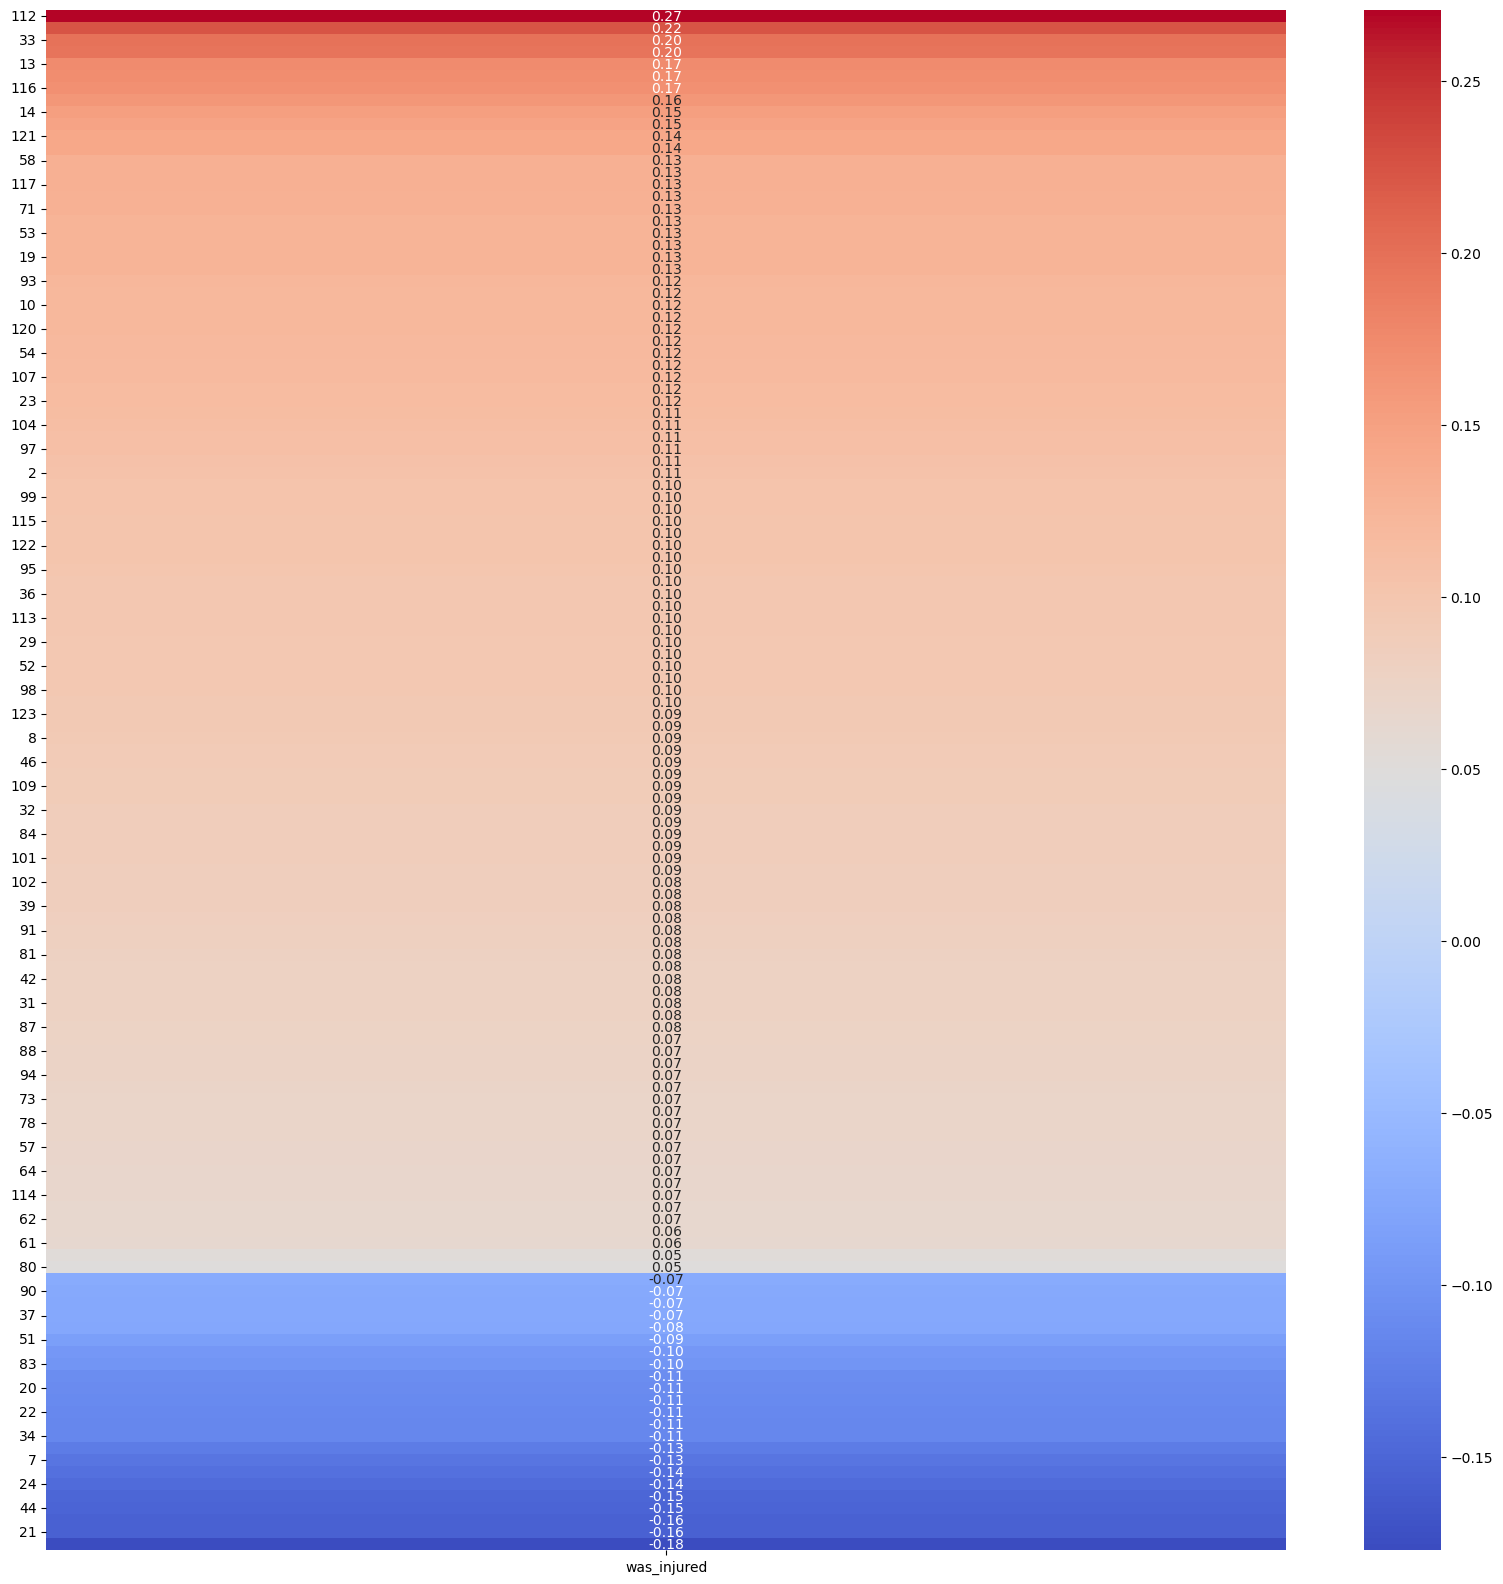

<Figure size 640x480 with 0 Axes>

In [32]:
#dis[lpay correlation matrix
new_df = pd.concat([X_train_resampled, y_train_resampled], axis=1)
corr = new_df.corr()[["was_injured"]].sort_values(by="was_injured", ascending=False)
corr = corr.drop("was_injured")
plt.figure(figsize=(20,20))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()
plt.savefig("correlation_matrix.png")

In [33]:
#import shuffler
from sklearn.utils import shuffle

In [34]:
X_train_injury = X_train[y_train == 1]
X_train_no_injury = X_train[y_train == 0]

print("X_train_injury shape:", X_train_injury.shape)
print("X_train_no_injury shape:", X_train_no_injury.shape)

X_train_no_injury_downsampled = resample(X_train_no_injury, replace=False, n_samples=len(X_train_injury), random_state=42)

X_train_downsampled = pd.concat([X_train_no_injury_downsampled, X_train_injury])
y_train_downsampled = pd.Series([0] * len(X_train_no_injury_downsampled) + [1] * len(X_train_injury))

#shuffle the data
X_train_downsampled, y_train_downsampled = shuffle(X_train_downsampled, y_train_downsampled, random_state=42)

print("X_train_downsampled shape:", X_train_downsampled.shape)

X_train_injury shape: (409, 128)
X_train_no_injury shape: (23301, 128)
X_train_downsampled shape: (818, 128)


In [35]:
classifiers = {
    "Logisitic Regression": LogisticRegression(),
    "SGD Classifier": SGDClassifier()
}

Classifier:  LogisticRegression
Classification Report: 
              precision    recall  f1-score   support

           0       0.99      0.68      0.80      2587
           1       0.03      0.56      0.06        48

    accuracy                           0.68      2635
   macro avg       0.51      0.62      0.43      2635
weighted avg       0.97      0.68      0.79      2635



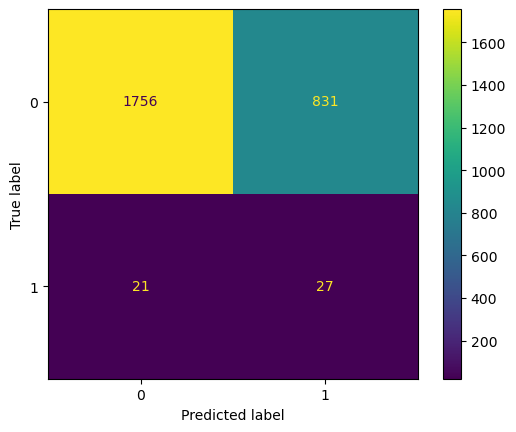

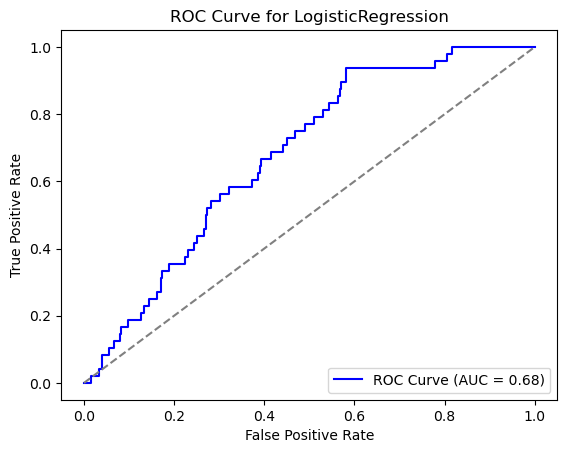

/Users/shrinivasvenkatesan/opt/anaconda3/envs/dev/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/shrinivasvenkatesan/opt/anaconda3/envs/dev/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-

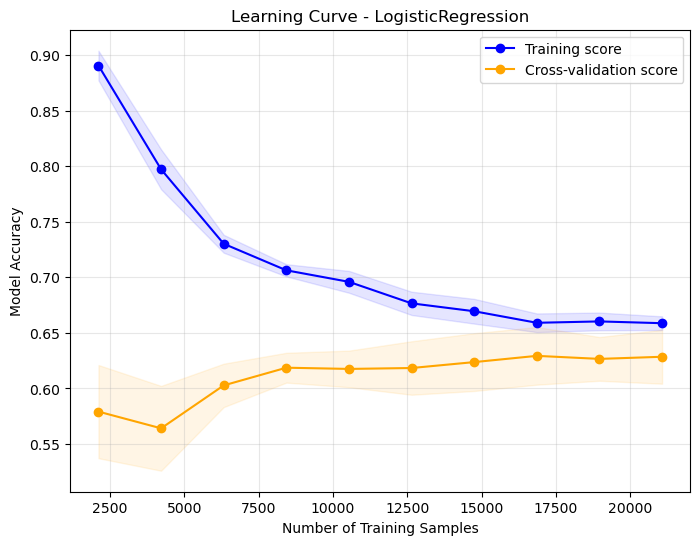

Classifier:  SGDClassifier
Classification Report: 
              precision    recall  f1-score   support

           0       0.99      0.62      0.76      2587
           1       0.03      0.65      0.06        48

    accuracy                           0.62      2635
   macro avg       0.51      0.63      0.41      2635
weighted avg       0.97      0.62      0.75      2635



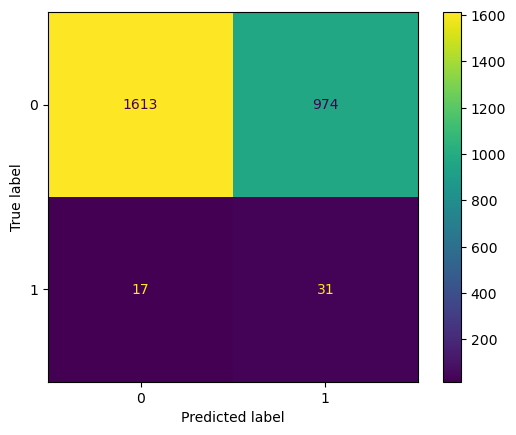

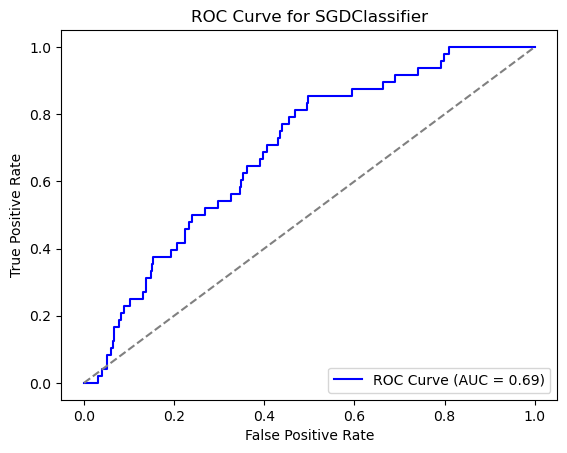

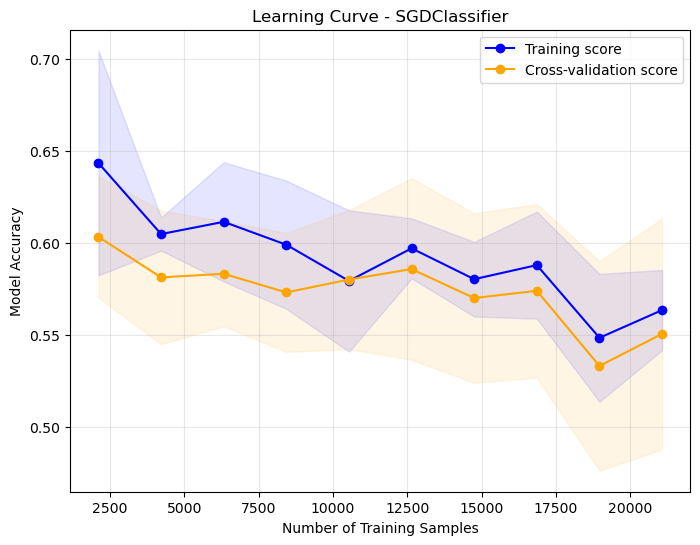

In [58]:
for key, classifier in classifiers.items():
    classifier.fit(X_train_resampled, y_train_resampled)
    print("Classifier: ", classifier.__class__.__name__)
    print("Classification Report: ")
    print(classification_report(y_test, classifier.predict(X_test)))

    cm = confusion_matrix(y_test, classifier.predict(X_test))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()
    if hasattr(classifier, "predict_proba"):  # For models that support probability prediction
        y_prob = classifier.predict_proba(X_test)[:, 1]
    elif hasattr(classifier, "decision_function"):  # For models like SVM that use decision_function
        y_prob = classifier.decision_function(X_test)
    else:
        print(f"Skipping ROC for {classifier.__class__.__name__}, no probability output available.")
        continue
    
    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    auc_score = roc_auc_score(y_test, y_prob)
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {auc_score:.2f})")
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for random guessing
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve for {classifier.__class__.__name__}")
    plt.legend(loc="lower right")
    plt.show()

    if hasattr(classifier, "predict_proba"):  # For models that support probability prediction
        scorer = make_scorer(roc_auc_score, needs_proba=True)

        # Generate the learning curve
        train_sizes, train_scores, test_scores = learning_curve(
            estimator=classifier,
            X=X,  # Entire dataset (X)
            y=y,  # Entire target labels (y)
            cv=5,  # 5-fold cross-validation
            scoring=scorer,
            train_sizes=np.linspace(0.1, 1.0, 10),  # Vary training set size from 10% to 100%
            n_jobs=-1  # Use all available CPU cores
        )

        # Calculate mean and standard deviation for training and test scores
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

        # Plot the learning curve
        plt.figure(figsize=(8, 6))
        plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Training score')
        plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='blue')
        plt.plot(train_sizes, test_scores_mean, 'o-', color='orange', label='Cross-validation score')
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='orange')
        plt.title(f'Learning Curve - {classifier.__class__.__name__}')
        plt.xlabel('Number of Training Samples')
        plt.ylabel('Model Accuracy')
        plt.legend(loc='best')
        plt.grid(alpha=0.3)
        plt.show()
    elif hasattr(classifier, "decision_function"):  # For models like SVM that use decision_function
        def custom_auc_scorer(estimator, X, y):
            decision_scores = estimator.decision_function(X)  # Get decision function scores
            return roc_auc_score(y, decision_scores)

        # # Wrap the scorer
        # scorer = make_scorer(custom_auc_scorer, greater_is_better=True, needs_proba=False, needs_threshold=True)
        scorer = make_scorer(roc_auc_score, greater_is_better=True, needs_proba=False, needs_threshold=True)
        # Generate the learning curve
        train_sizes, train_scores, test_scores = learning_curve(
            estimator=classifier,
            X=X,  # Entire feature set
            y=y,  # Target labels
            cv=5,  # 5-fold cross-validation
            scoring=scorer,  # Pass custom scorer directly
            train_sizes=np.linspace(0.1, 1.0, 10),  # Training sizes from 10% to 100%
            n_jobs=-1  # Use all available cores
        )

        # Calculate mean and standard deviation for training and test scores
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

        # Plot the learning curve
        plt.figure(figsize=(8, 6))
        plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Training score')
        plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='blue')
        plt.plot(train_sizes, test_scores_mean, 'o-', color='orange', label='Cross-validation score')
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='orange')
        plt.title('Learning Curve - SGDClassifier')
        plt.xlabel('Number of Training Samples')
        plt.ylabel('Model Accuracy')
        plt.legend(loc='best')
        plt.grid(alpha=0.3)
        plt.show()

In [37]:
import torch
import torch.nn as nn
import torch.optim as optim

In [38]:
print(X_train_resampled.shape)
print(y_train_resampled.shape)

print(X_train_downsampled.shape)
print(y_train_downsampled.shape)

(46602, 128)
(46602,)
(818, 128)
(818,)


In [39]:
X_train_resampled = torch.tensor(X_train_resampled.values).float()
y_train_resampled = torch.tensor(y_train_resampled.values).float()

X_train_downsampled = torch.tensor(X_train_downsampled.values).float()
y_train_downsampled = torch.tensor(y_train_downsampled.values).float()

In [40]:
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test.values).float()

ValueError: could not determine the shape of object type 'Series'

In [ ]:
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)

        out = self.fc2(out)
        out = self.relu(out)

        out = self.fc3(out)
        out = self.sigmoid(out)

        return out
    

Epoch 0 Loss: 0.6920942664146423
Epoch 5 Loss: 0.6752457618713379
Epoch 10 Loss: 0.6566150188446045
Epoch 15 Loss: 0.6363252401351929
Epoch 20 Loss: 0.6162330508232117
Classification Report: 
              precision    recall  f1-score   support

         0.0       0.99      0.69      0.81      2587
         1.0       0.03      0.48      0.05        48

    accuracy                           0.69      2635
   macro avg       0.51      0.58      0.43      2635
weighted avg       0.97      0.69      0.80      2635



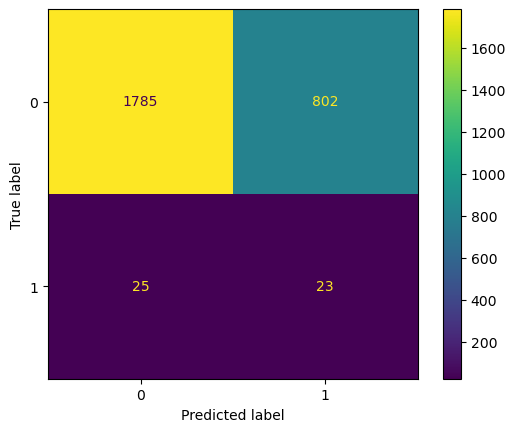

In [ ]:
model = NeuralNet()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(25):
    optimizer.zero_grad()
    outputs = model(X_train_resampled)
    loss = criterion(outputs.squeeze(), y_train_resampled)
    loss.backward()
    optimizer.step()
    if epoch % 5 == 0:
        print(f"Epoch {epoch} Loss: {loss.item()}")

with torch.no_grad():
    outputs = model(X_test)
    predicted = torch.round(outputs).squeeze()
    print("Classification Report: ")
    print(classification_report(y_test, predicted.numpy()))
    cm = confusion_matrix(y_test, predicted.numpy())
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()